In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("using Google CoLab")
except:
    print("not using Google CoLab")
    COLAB = False

using Google CoLab


In [2]:
if COLAB:
  !pip install datasets
  !pip install transformers==3
  !pip install -U torchtext==0.8.0
  !pip install protobuf

Requirement already up-to-date: torchtext==0.8.0 in /usr/local/lib/python3.7/dist-packages (0.8.0)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import torch
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

In [6]:
from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator

In [7]:
data_path = '/content/drive/MyDrive/data/tweets_hate_speech_detection'

In [8]:
from datasets import load_dataset
dataset_dict = load_dataset('tweets_hate_speech_detection', split='train')
df = pd.DataFrame.from_records(dataset_dict)

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c32a982d8b2d6233065d820ac655454174f8aaa8faddc74979cf793486acd3b0)


Count of label 0 (non hate specch) is: 29720 and for label 1 (hate specch) is: 2242 




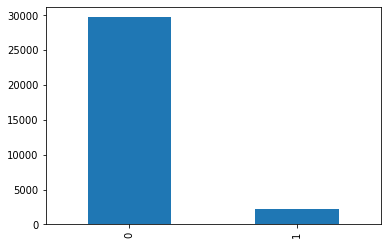

In [9]:
counts = df['label'].value_counts()
print(f"Count of label 0 (non hate specch) is: {counts[0]} and for label 1 (hate specch) is: {counts[1]}","\n\n")
counts.plot.bar()

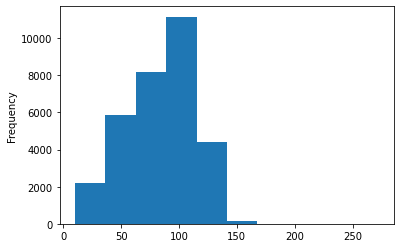

In [10]:
tweet_length = df['tweet'].str.len().plot.hist()

Text(0.5, 1.0, 'Most Frequently 20 Word')

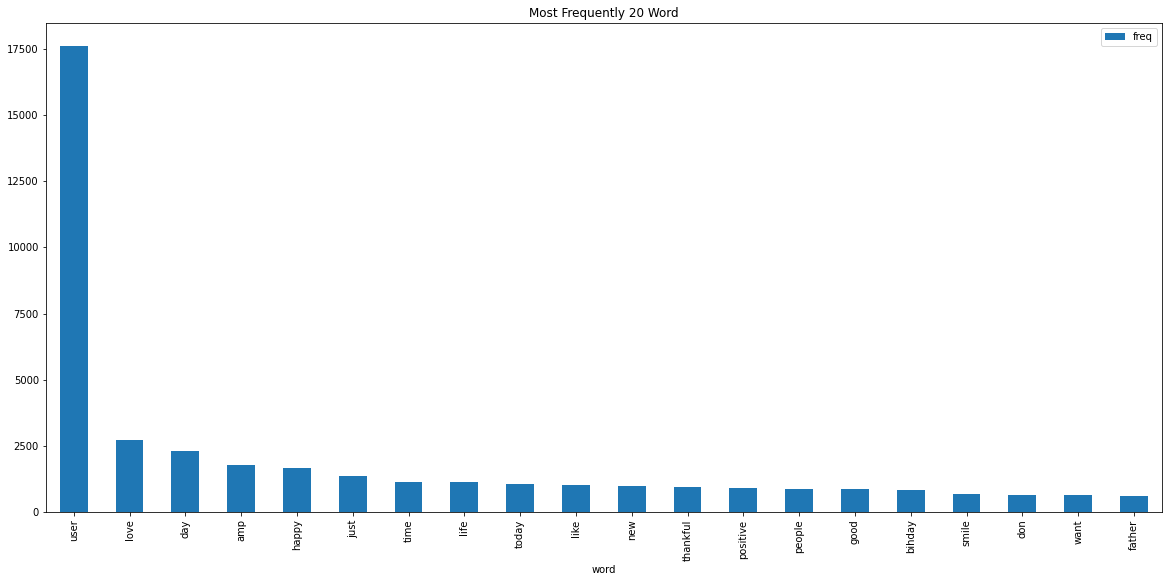

In [11]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.tweet)
sum_words = np.squeeze(np.asarray(words.sum(axis=0)))
words_count = [(word, sum_words[i]) for word, i in cv.vocabulary_.items()]
words_count = sorted(words_count, key = lambda x: x[1], reverse = True)
counts = pd.DataFrame(words_count, columns=['word', 'freq'])
counts.head(20).plot(x='word', y='freq', kind='bar', figsize = (20,9))
plt.title("Most Frequently 20 Word")

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [13]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [14]:
# Save preprocessed data, cropped to max length of the model.
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.split()[:512]))
df.to_csv(f"{data_path}/prep_tweets.csv")

In [15]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
path = f"{data_path}/prep_tweets.csv"

# Define columns to read.
label_field = Field(sequential=False,  use_vocab=False, batch_first=True)

text_field = Field(use_vocab=False, tokenize=tokenizer.encode, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

fields = {'tweet' : ('tweet', text_field),'label' : ('label', label_field)}


In [16]:
dataset = TabularDataset(path= path, format='CSV', fields=fields, skip_header=False)
train_data, valid_data, test_data = dataset.split(split_ratio=[0.70, 0.2, 0.1],  stratified=True, strata_field='label')

In [17]:
# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.tweet), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [18]:
print(RobertaModel.from_pretrained('roberta-base'))

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [19]:
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 128)
        self.bn1 = torch.nn.LayerNorm(128)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(128, 2)
        torch.nn.init.xavier_uniform(self.l1.weight)
        torch.nn.init.xavier_uniform(self.l2.weight)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x

In [20]:
output_path = data_path

In [21]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Hate', 'Normal'])
    ax.yaxis.set_ticklabels(['Hate', 'Normal'])

Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       448
           0     0.9299    1.0000    0.9637      5944

    accuracy                         0.9299      6392
   macro avg     0.4650    0.5000    0.4818      6392
weighted avg     0.8647    0.9299    0.8961      6392



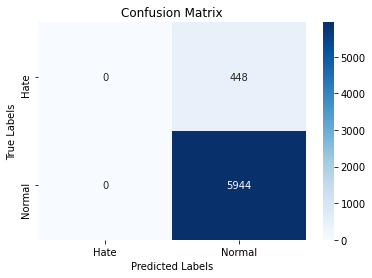

In [22]:
model = ROBERTAClassifier()
model = model.to(device)
evaluate(model, test_iter)

In [23]:
class ResultsSaver():
  def __init__(self, train_len, val_len,output_path):
    self.train_losses = []
    self.val_losses = []
    self.steps = []
    
    self.best_val_loss = float('Inf')
    
    self.train_len = train_len
    self.val_len = val_len
    
    self.output_path = output_path
  
  def save_checkpoint(self, path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),'valid_loss': valid_loss}, self.output_path + path)

  def load_checkpoint(self, path, model):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

  def save_metrics(self, path):   
    state_dict = {'train_losses': self.train_losses,
                  'val_losses': self.val_losses,
                  'steps': self.steps}
    
    torch.save(state_dict, self.output_path + path)
  
  def load_metrics(self, path):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    return state_dict['train_losses'], state_dict['val_losses'], state_dict['steps']

  def update_train_val_loss(self, model, train_loss, val_loss, step, epoch, num_epochs):

    train_loss = train_loss / self.train_len
    val_loss = val_loss / self.val_len
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.steps.append(step)
    

    # print summary
    print('Epoch [{}/{}], step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}' .format(epoch+1, num_epochs, step, num_epochs * self.train_len, train_loss, val_loss))
    
    # checkpoint
    if self.best_val_loss > val_loss:
        self.best_val_loss = val_loss
        self.save_checkpoint('/model.pkl', model, self.best_val_loss)
        self.save_metrics('/metric.pkl')


In [24]:
def train(model, optimizer, train_iter, valid_iter, results, scheduler = None, num_epochs = 5 , train_whole_model = False):
    step = 0
    if train_whole_model:
      for param in model.roberta.parameters():
        param.requires_grad = True
    else:
      for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = 0.0                
        val_loss = 0.0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            y_pred = model(input_ids=source, attention_mask=mask)  
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            loss.backward()
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
            optimizer.zero_grad()
            # Update train loss and step
            train_loss += loss.item()
            step += 1

        model.eval()
        with torch.no_grad():                    
            for (source, target), _ in valid_iter:
                mask = (source != PAD_INDEX).type(torch.uint8)
                y_pred = model(input_ids=source,  attention_mask=mask)
                loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                val_loss += loss.item()
        results.update_train_val_loss(model, train_loss, val_loss, step, epoch, num_epochs)       
        model.train()

    results.save_metrics('/metric.pkl')

In [25]:
# Main training loop
NUM_EPOCHS_1 = 6
steps_per_epoch = len(train_iter)
model = ROBERTAClassifier(0.4)
model = model.to(device)
results = ResultsSaver(len(train_iter), len(valid_iter), output_path)


print(" ............. Training the added Layers only ............. ")
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer,  num_warmup_steps=steps_per_epoch*1,  
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS_1)

train(model=model, train_iter=train_iter, valid_iter=valid_iter, optimizer=optimizer, 
      results = results, scheduler=scheduler, num_epochs=NUM_EPOCHS_1, train_whole_model = False)


print(" ............. Training the whole Model ............. ")
NUM_EPOCHS_2 = 6
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS_2)

train(model=model,  train_iter=train_iter,  valid_iter=valid_iter,  optimizer=optimizer, 
      results = results,  scheduler=scheduler,  num_epochs=NUM_EPOCHS_2, train_whole_model=True)

 ............. Training the added Layers only ............. 
Epoch [1/6], step [1399/8394], Train Loss: 0.3194, Valid Loss: 0.3495
Epoch [2/6], step [2798/8394], Train Loss: 0.2883, Valid Loss: 0.2963
Epoch [3/6], step [4197/8394], Train Loss: 0.2703, Valid Loss: 0.2798
Epoch [4/6], step [5596/8394], Train Loss: 0.2658, Valid Loss: 0.2662
Epoch [5/6], step [6995/8394], Train Loss: 0.2602, Valid Loss: 0.2534
Epoch [6/6], step [8394/8394], Train Loss: 0.2561, Valid Loss: 0.2481
 ............. Training the whole Model ............. 
Epoch [1/6], step [1399/8394], Train Loss: 0.2177, Valid Loss: 0.1454
Epoch [2/6], step [2798/8394], Train Loss: 0.1506, Valid Loss: 0.1212
Epoch [3/6], step [4197/8394], Train Loss: 0.1220, Valid Loss: 0.1126
Epoch [4/6], step [5596/8394], Train Loss: 0.1008, Valid Loss: 0.1137
Epoch [5/6], step [6995/8394], Train Loss: 0.0854, Valid Loss: 0.1107
Epoch [6/6], step [8394/8394], Train Loss: 0.0762, Valid Loss: 0.1108


In [26]:
steps = []
for i, step in enumerate(results.steps):
  if i < NUM_EPOCHS_1:
    steps.append(results.steps[i])
  else:
    steps.append(results.steps[i] + results.steps[NUM_EPOCHS_1-1])

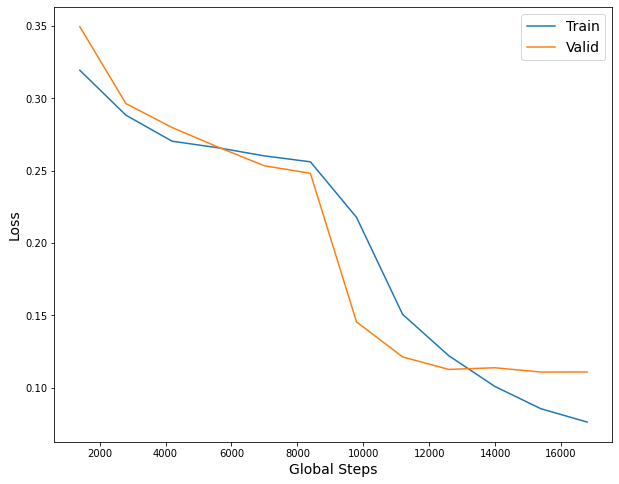

In [27]:
plt.figure(figsize=(10, 8))
#train_loss_list, valid_loss_list, global_steps_list = results.load_metrics(output_path + '/metric.pkl')
plt.plot(steps, results.train_losses , label='Train')
plt.plot(steps, results.val_losses,  label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [28]:
model = ROBERTAClassifier()
model = model.to(device)

results.load_checkpoint('/model.pkl', model)

0.11072421715027303

Classification Report:
              precision    recall  f1-score   support

           1     0.7773    0.7321    0.7540       448
           0     0.9799    0.9842    0.9820      5944

    accuracy                         0.9665      6392
   macro avg     0.8786    0.8582    0.8680      6392
weighted avg     0.9657    0.9665    0.9661      6392



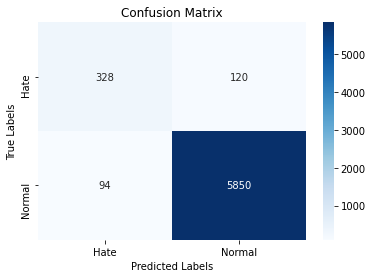

In [29]:
evaluate(model, test_iter)

# Appendix

#view Words Cloud

Source code: https://github.com/sharmaroshan/Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment.ipynb

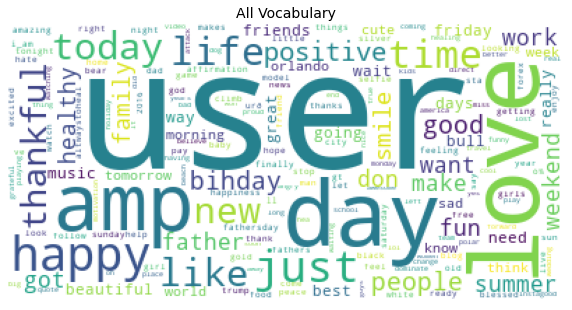

In [30]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(dict(words_count))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("All Vocabulary", fontsize = 14)
plt.show()

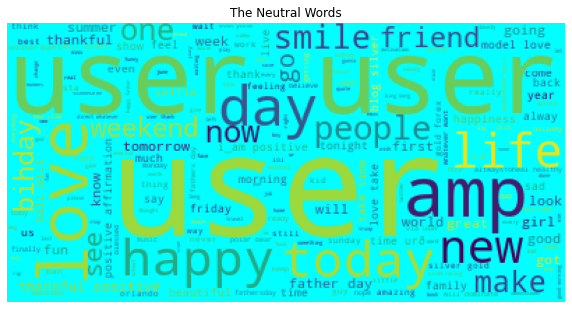

In [31]:
normal_words =' '.join([text for text in df['tweet'][df['label'] == 0]])
wordcloud = WordCloud(background_color = 'cyan').generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

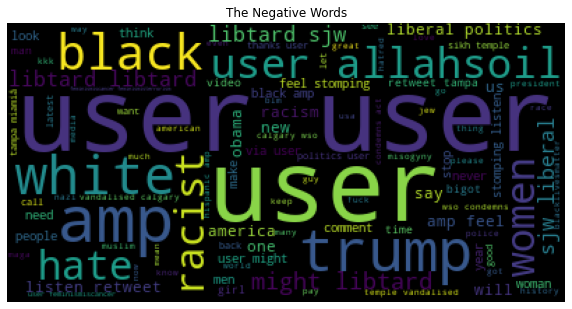

In [32]:
negative_words =' '.join([text for text in df['tweet'][df['label'] == 1]])
wordcloud = WordCloud().generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The Negative Words')
plt.show()

# Hashtags 

In [33]:
# collecting the hashtags
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [34]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(df['tweet'][df['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(df['tweet'][df['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

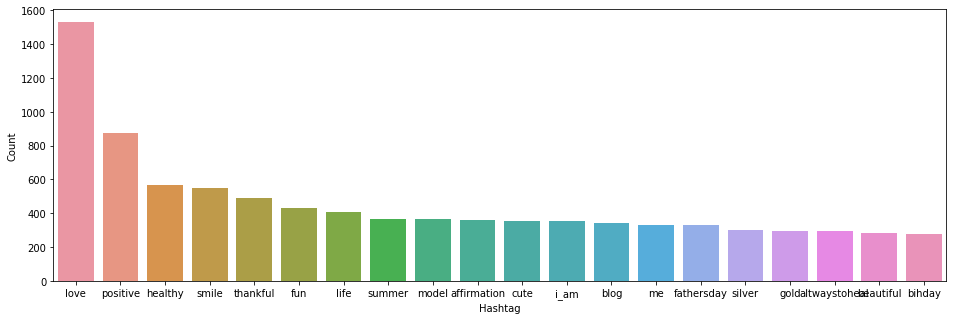

In [35]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

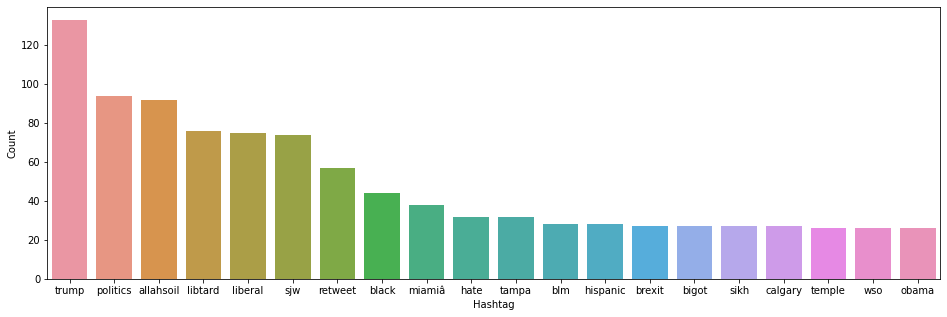

In [36]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()